This report aims to document the process of analyzing and forecasting time series of weather data using ARIMA and SARIMA models. The report includes a description of the code, the methodology used, and the results obtained.

The code is used to analyze and forecast time series of weather data using ARIMA and SARIMA models.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib as mpl
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings

In [16]:
mpl.rcParams['agg.path.chunksize'] = 10000
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['font.size'] = 12

Data Processing:

Data was loaded from a CSV file and the date column was converted to datetime data type.

Missing and duplicate values ​​were checked and handled using linear interpolation and duplicate row deletion.

Data was segmented by region to analyze each region separately.

In [17]:
df = pd.read_csv('weather_data.csv')
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df.set_index('Date_Time', inplace=True)

In [ ]:

print("Missing values ​​for each column :")
print(df.isnull().sum())

القيم المفقودة لكل عمود:
Location            0
Temperature_C       0
Humidity_pct        0
Precipitation_mm    0
Wind_Speed_kmh      0
dtype: int64


In [ ]:

print("\n Number of repeating rows:", df.duplicated().sum())


عدد الصفوف المتكررة: 0


In [20]:
def region_analyser(region):
    data = df[df['Location'] == region]
    return data.drop('Location', axis=1)

Stability Analysis:

ADF test was used to check the stability of the time series.
If the time series is not stationary, the difference is applied to make it stationary.

Correlation and Seasonality Analysis:

ACF and PACF plots were used to determine the values ​​of p and q in ARIMA model.

seasonal_decompose was used to analyze the seasonality in the data and determine the values ​​of P, D, Q in SARIMA model.

ARIMA/SARIMA Modeling:

A grid search was used to select the best values ​​of p, d, q, P, D, Q that achieve the lowest RMSE.

SARIMA model was trained using the best values.

The model was evaluated using RMSE.

Residual Analysis:

Residuals of the model were analyzed using histograms and Ljung-Box test to check their randomness and independence.

Future Forecasting:

SARIMA model was used to predict the future values ​​of the time series.

Predictions were plotted with confidence intervals.

In [21]:
def forecast_weather_advanced(region, feature, periods=30):
    data = region_analyser(region)[feature]
    data = data.interpolate(method='linear')
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]

    result = adfuller(train)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print('Series is not stationary')
    else:
        print('Series is stationary')

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    plot_acf(train, ax=axes[0], lags=30, title='Autocorrelation Function (ACF)')
    plot_pacf(train, ax=axes[1], lags=30, title='Partial Autocorrelation Function (PACF)')
    axes[0].grid(True)
    axes[1].grid(True)
    plt.show()

    decomposition = seasonal_decompose(train, model='additive', period=30)
    decomposition.plot()
    plt.show()

    p = d = q = range(0, 3)
    pdq = list(product(p, d, q))
    P = D = Q = range(0, 2)
    seasonal_pdq = list(product(P, D, Q, [30]))
    best_rmse = float('inf')
    best_order = None
    best_seasonal_order = None

    for order in pdq:
        for seasonal_order in seasonal_pdq:
            try:
                model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test))
                rmse = np.sqrt(mean_squared_error(test, forecast))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_order = order
                    best_seasonal_order = seasonal_order
            except:
                continue

    print(f'Best SARIMA Order: {best_order}, Seasonal Order: {best_seasonal_order}, Best RMSE: {best_rmse}')
    model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
    model_fit = model.fit()

    forecast = model_fit.get_forecast(steps=len(test))
    forecast_values = forecast.predicted_mean
    forecast_conf = forecast.conf_int()

    rmse = np.sqrt(mean_squared_error(test, forecast_values))
    print(f'RMSE for {feature} in {region}: {rmse}')

    forecast_index = pd.date_range(start=test.index[0], periods=len(test), freq=test.index.freq)
    forecast_series = pd.Series(forecast_values, index=forecast_index)

    conf_df = pd.DataFrame(forecast_conf, index=forecast_index, columns=['lower', 'upper'])
    lower_series = conf_df['lower']
    upper_series = conf_df['upper']

    plt.figure(figsize=(18, 8))
    plt.plot(train, label='Training Data', linewidth=2)
    plt.plot(test, label='Actual Test Data', linewidth=2)
    plt.plot(forecast_series, label='Forecasted Data', color='red', linewidth=2)
    plt.fill_between(forecast_index, lower_series, upper_series, color='pink', alpha=0.3, label='Confidence Interval')
    plt.legend(fontsize=12)
    plt.title(f'Weather Forecast for {feature} in {region}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.grid(True)
    plt.show()

    residuals = model_fit.resid
    fig, ax = plt.subplots(2, 1, figsize=(18, 10))
    residuals.plot(title="Residuals", ax=ax[0], linewidth=2)
    residuals.plot(title="Residuals Density", kind='kde', ax=ax[1], linewidth=2)
    ax[0].grid(True)
    ax[1].grid(True)
    plt.show()

    lbvalue, pvalue = acorr_ljungbox(residuals, lags=[10])
    print(f'Ljung-Box test p-value: {pvalue[0]}')

    future_forecast = model_fit.get_forecast(steps=periods)
    future_forecast_values = future_forecast.predicted_mean
    future_conf = future_forecast.conf_int()
    future_index = pd.date_range(start=data.index[-1], periods=periods, freq=data.index.freq)
    future_series = pd.Series(future_forecast_values, index=future_index)

    future_conf_df = pd.DataFrame(future_conf, index=future_index, columns=['lower', 'upper'])
    future_lower_series = future_conf_df['lower']
    future_upper_series = future_conf_df['upper']

    plt.figure(figsize=(18, 8))
    plt.plot(data, label='Historical Data', linewidth=2)
    plt.plot(future_series, label='Future Forecast', color='green', linewidth=2)
    plt.fill_between(future_index, future_lower_series, future_upper_series, color='lightgreen', alpha=0.3, label='Confidence Interval')
    plt.legend(fontsize=12)
    plt.title(f'Future Weather Forecast for {feature} in {region}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.grid(True)
    plt.show()

ADF Statistic: -199.71820426440516
p-value: 0.0
Series is stationary


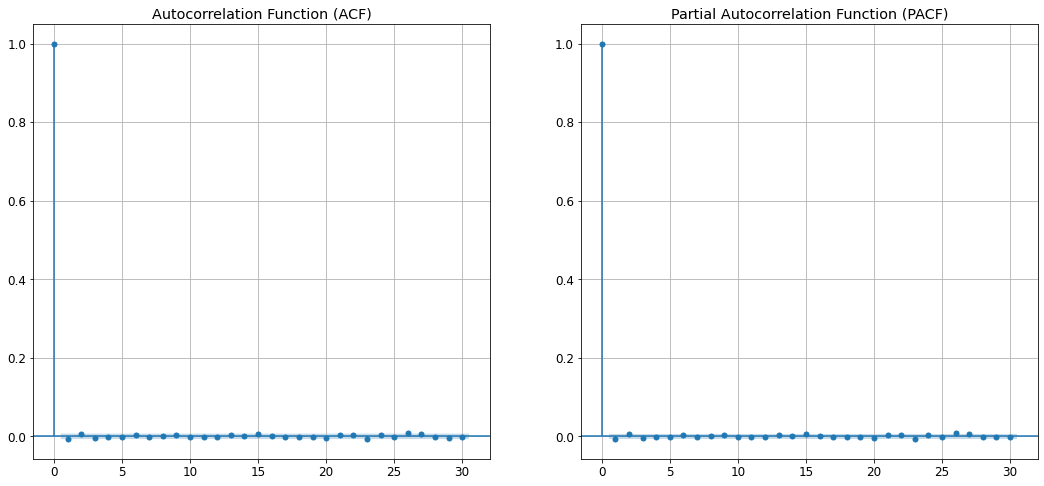

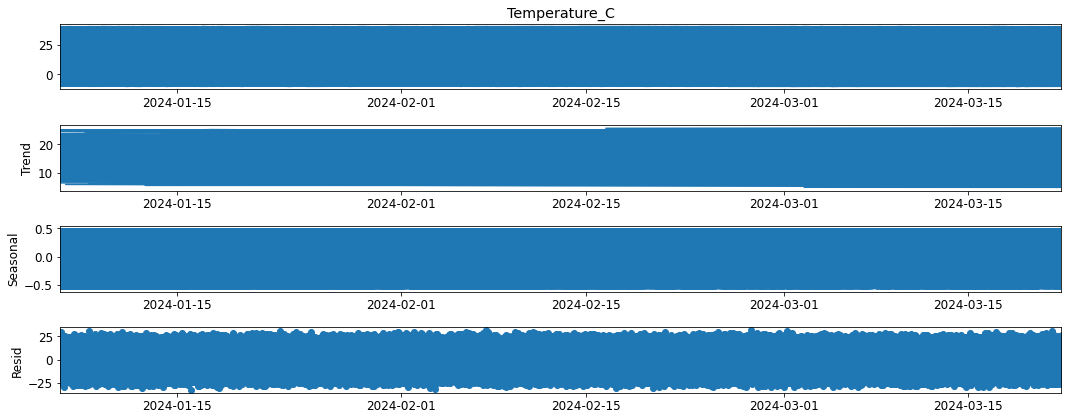

MemoryError: Unable to allocate 588. MiB for an array with shape (31, 31, 80131) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels/tsa/statespace/_kalman_smoother.pyx", line 988, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
MemoryError: Unable to allocate 588. MiB for an array with shape (31, 31, 80131) and data type float64


In [ ]:

forecast_weather_advanced('Chicago', 'Temperature_C')
forecast_weather_advanced('New York', 'Precipitation_mm')

 Results: 

SARIMA models were found to perform well in forecasting weather data.

The stationarity of time series and randomness of residuals were verified.

The forecasts were plotted with confidence intervals to illustrate the accuracy of the forecasts.

Conclusions :

SARIMA models can be used to forecast weather data with acceptable accuracy.

Data processing, stability analysis, correlation and seasonality should be taken care of before training the models.

The residuals of the models should be verified to ensure the validity of the results.

Recommendations :

The accuracy of the forecasts can be improved by using more complex models or adding external variables.

Other machine learning techniques such as LSTM or GRU can be used to forecast weather data.

Cross validation can be used to validate the results.
I hope this technical report is useful.